# **Decision Trees**
---
##Author: Emmanuel Paalam
##V1: Cleaned only
##Target variable: F3EVERDO

## Import data

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount("/content/drive")
## Insert pathway to dataset below
df = pd.read_csv("/content/drive/My Drive/research/SURP 2024/colab/data/cleaned/epaalam-cleaned_els_02_12_byf3pststu_v1_0.csv")

df.dropna(inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.shape

(2484, 212)

## Split data

In [ ]:
y = df['F3EVERDO']
y.shape

(2484,)

In [ ]:
X = df.drop(columns='F3EVERDO', axis=1)
X.shape

(2484, 211)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58, stratify=y)
print(f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

(1987, 211), (497, 211), (1987,), (497,)


##Model development

###Define parameters, scoring

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [10, 30, 90]
    }

In [ ]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'specificity': make_scorer(specificity_score),
    'npv': make_scorer(npv_score)
}

###Cross-validate/fit

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=978), param_grid=param_grid, scoring=scoring, refit='f1', cv=StratifiedKFold(n_splits=5), n_jobs=-1, return_train_score=True)

In [ ]:
grid_search.fit(X_train, y_train)

# Access and print the cv_results_
results = grid_search.cv_results_

# Print the relevant metrics
print("Mean Test Accuracy:", results['mean_test_accuracy'])
print("Mean Test Precision:", results['mean_test_precision'])
print("Mean Test Recall:", results['mean_test_recall'])
print("Mean Test F1:", results['mean_test_f1'])
print("Mean Test Specificity:", results['mean_test_specificity'])
print("Mean Test NPV:", results['mean_test_npv'])

Mean Test Accuracy: [0.94966773 0.95721935 0.95973824 0.94865891 0.95973317 0.96074073
 0.94865891 0.95973317 0.96074073]
Mean Test Precision: [0.81849566 0.86978483 0.94952374 0.81333294 0.89399891 0.95196465
 0.81333294 0.89399891 0.95196465]
Mean Test Recall: [0.81856099 0.81968895 0.74220526 0.81460962 0.79858053 0.7515909
 0.81460962 0.79858053 0.7515909 ]
Mean Test F1: [0.81679515 0.83639765 0.80665269 0.81295339 0.83346325 0.81336347
 0.81295339 0.83346325 0.81336347]
Mean Test Specificity: [0.97229439 0.9809871  0.99728408 0.97174797 0.98750589 0.99674502
 0.97174797 0.98750589 0.99674502]
Mean Test NPV: [0.97338969 0.97316184 0.96081218 0.9728268  0.96968867 0.96232303
 0.9728268  0.96968867 0.96232303]


In [ ]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

Best parameters found:  {'criterion': 'gini', 'min_samples_split': 30}
Best cross-validation score: 0.84


### Observe metrics

Accuracy: 0.9496981891348089
Precision: 0.6410256410256411
Recall: 0.6944444444444444
F1 Score: 0.6666666666666666
ROC-AUC: 0.9126596770306098
Specificity: 0.9696312364425163
Test Negative Predictive Value (NPV): 0.9759825327510917
Confusion Matrix:
[[447  14]
 [ 11  25]]


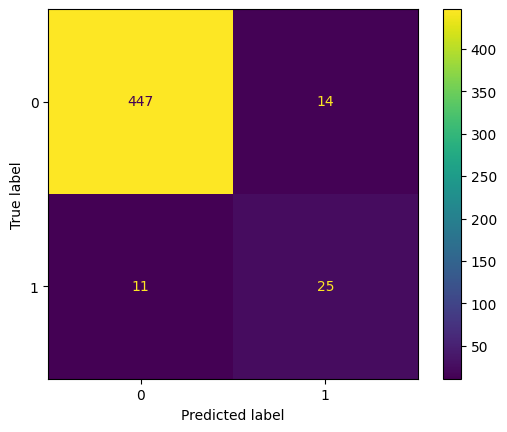

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate specificity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Calculate test negative predictive value (NPV)
test_npv = tn / (tn + fn)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Specificity: {specificity}")
print(f'Test Negative Predictive Value (NPV): {test_npv}')
print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot()

##Tree visual

In [ ]:
!pip install graphviz
!pip install pydotplus

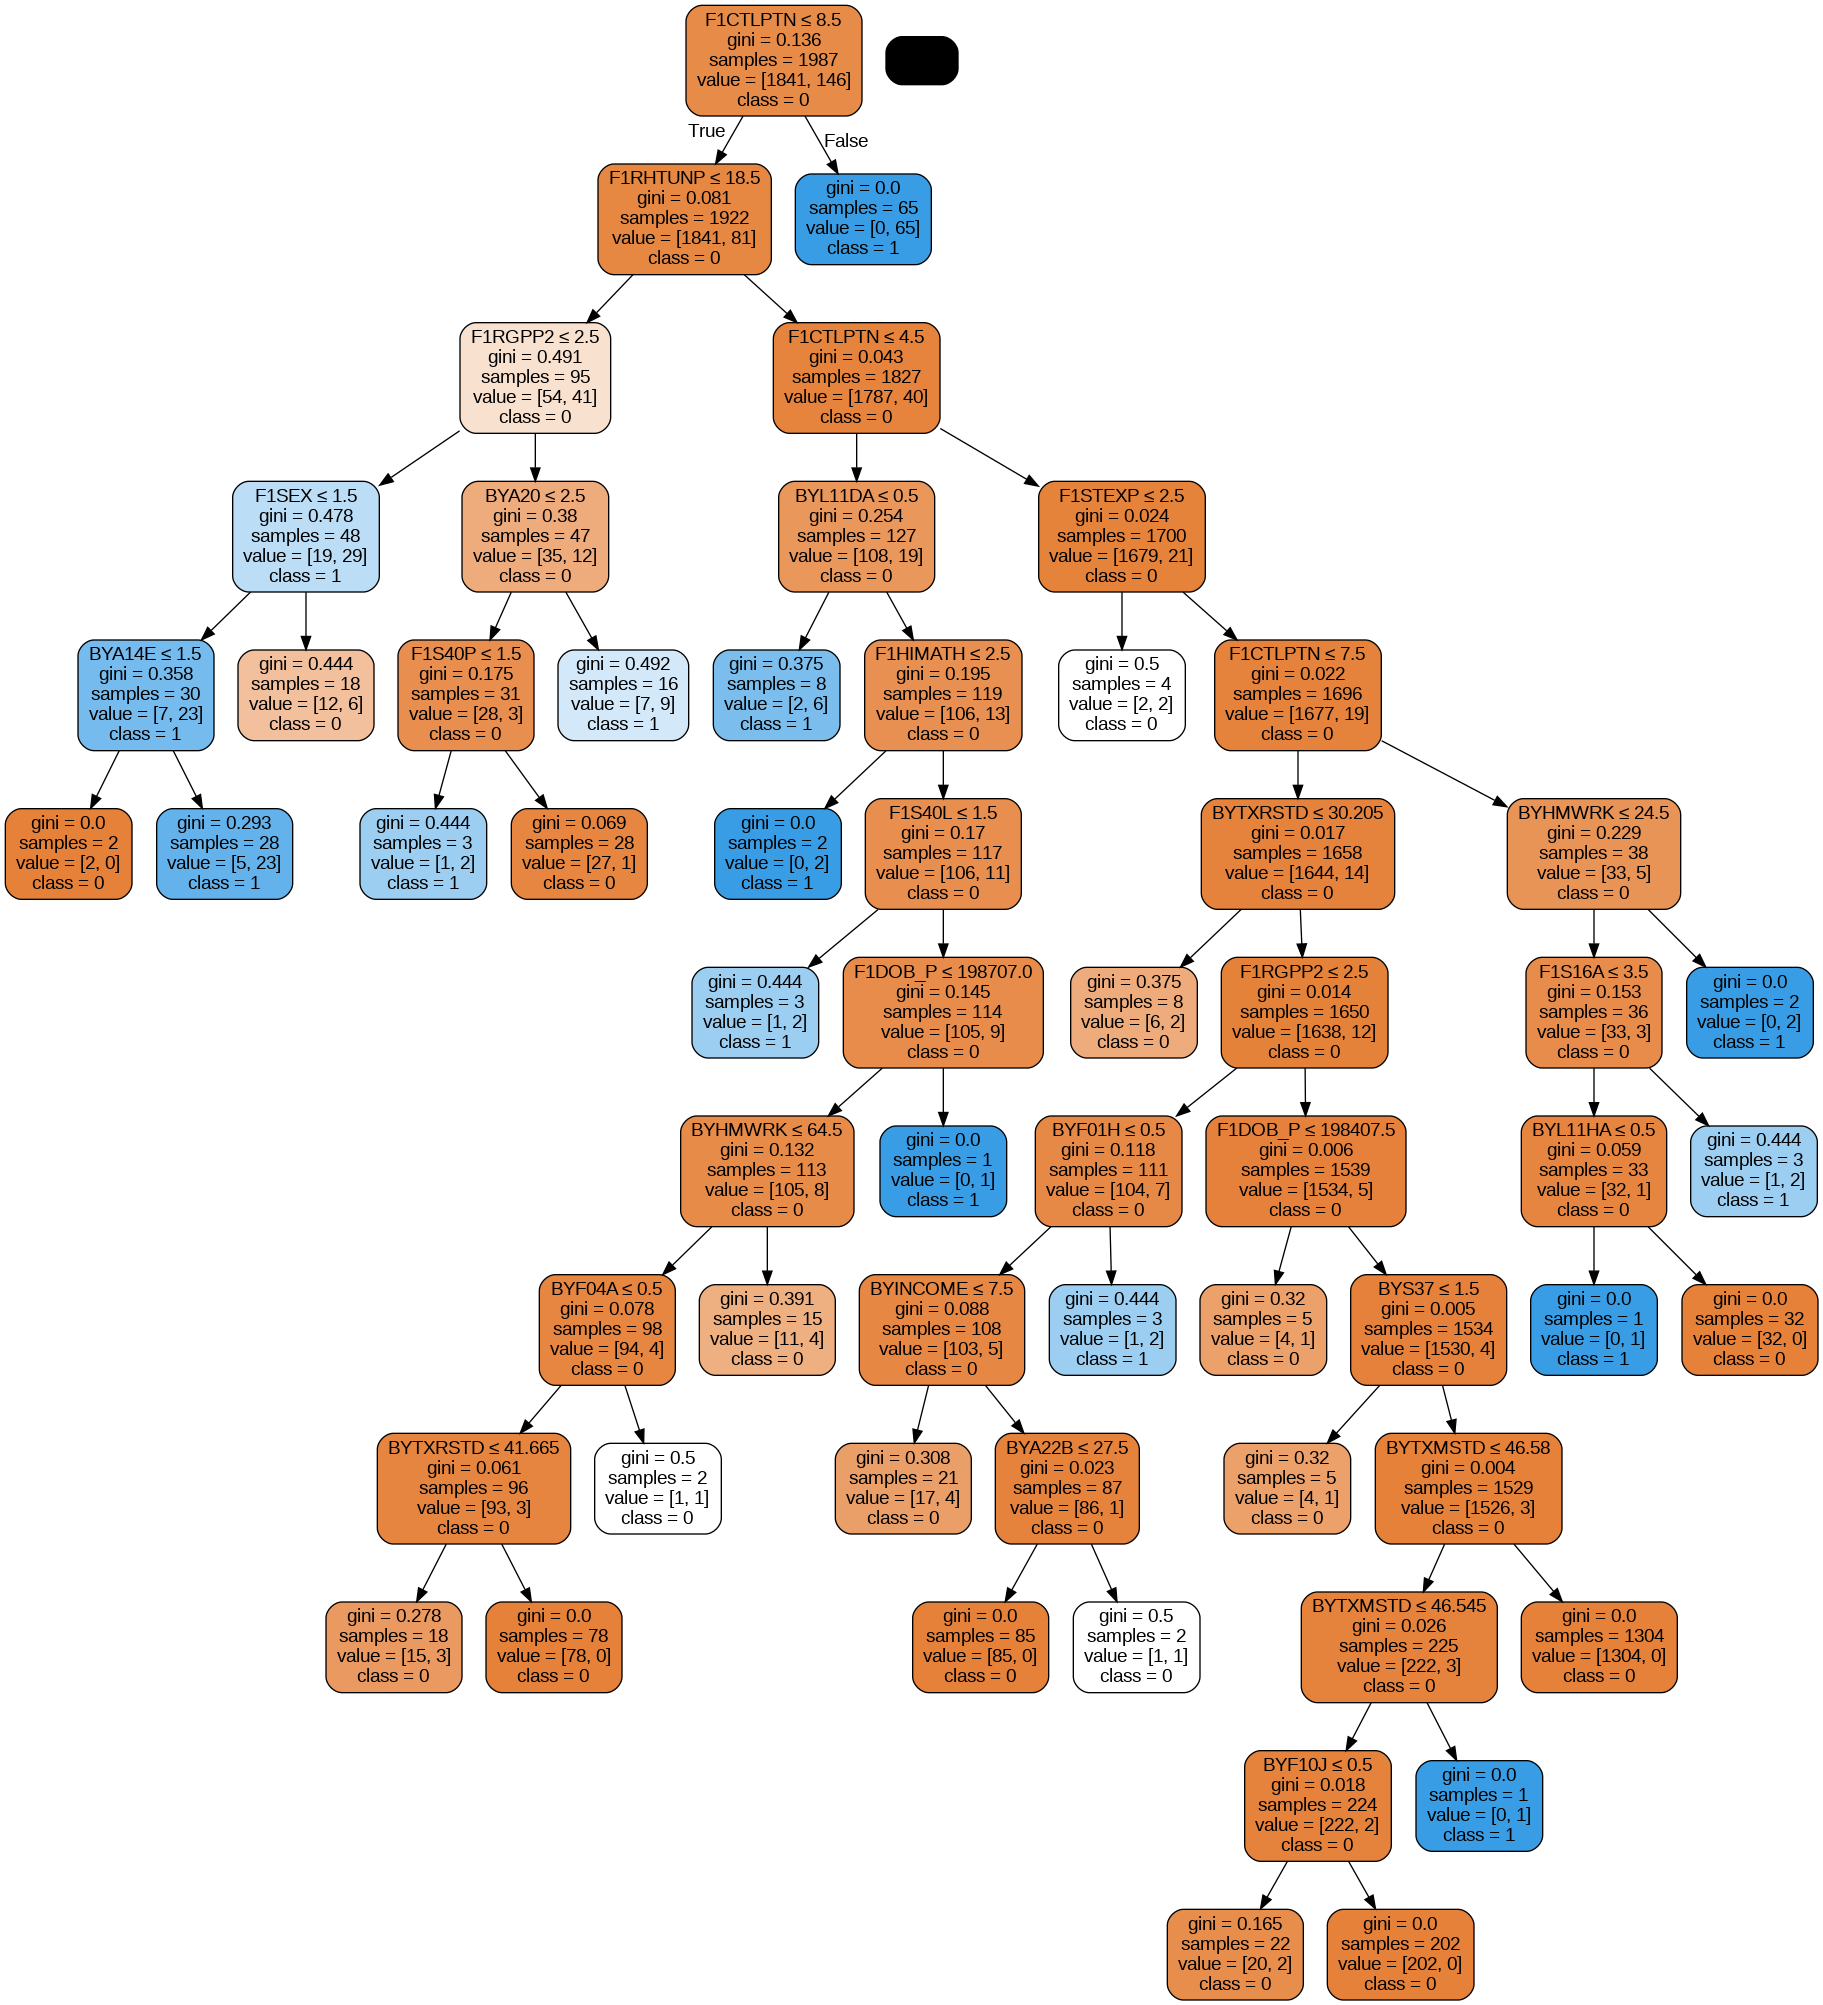

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(best_model, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns.tolist(),class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('dropout_prediction.png')
Image(graph.create_png())